In [1]:
#################################################
################  Import things #################
#################################################

import numpy as np
import timeit
import random
import copy
import matplotlib.pyplot as plt
from sklearn import datasets
import pickle
from scipy import stats
import glycowork
import pandas as pd

from glycowork.glycan_data.loader import glycan_binding as gb
from glycowork.glycan_data.loader import df_glycan as df_glycan
from glycowork.glycan_data.loader import glycomics_data_loader

In [ ]:
# need to previously `run pip3 install esm`
import esm.pretrained
from glycowork.ml.inference import get_esm1b_representations, get_lectin_preds
from glycowork.ml.models import prep_model


model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S() # will need to download if the first time
leor = prep_model('LectinOracle', 1, trained = True)

filename = '/Users/csfloyd/Dropbox/Projects/GlycanAnalysis/Data/LectinOracleReps_keep.pkl'
with open(filename, 'rb') as file:
    reps = pickle.load(file)


prot_to_seq = gb.groupby('protein')['target'].first()
prot_seqs = gb['protein'].map(prot_to_seq).tolist()

# Check what characters are in your sequences
import string
def analyze_sequences(seqs):
    all_chars = set()
    valid_seqs = []
    invalid_seqs = []
    for i, seq in enumerate(seqs):

        if not isinstance(seq, str):
            print(f"Sequence {i} is not a string, it's a {type(seq)}: {seq}")
            invalid_seqs.append(i)
            continue
        
        chars = set(seq)
        all_chars.update(chars)
        # Check for any characters that aren't standard amino acids
        invalid_chars = chars - set('ABRNDCEQGHILKMFPSTWYVX')
        if invalid_chars:
            print(f"Sequence {i} has invalid characters: {invalid_chars}")
            print(f"Full sequence: {seq}")
            invalid_seqs.append(seq)
        else:
            valid_seqs.append(seq)  
    print("\nAll unique characters found:", sorted(all_chars))
    return invalid_seqs, valid_seqs

# Analyze your sequences
prot_to_seq = gb.groupby('protein')['target'].first()
prot_seqs = gb['protein'].map(prot_to_seq).tolist()
invalid_seqs, valid_seqs = analyze_sequences(prot_seqs)

C:\Users\csfloyd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
from glycowork.glycan_data.loader import lib as lib

In [26]:
display(lib)

{'!GlcNAc': 0,
 '-10': 1,
 '-12': 2,
 '-2': 3,
 '-4': 4,
 '-6': 5,
 '-8': 6,
 '0dHex': 7,
 '1,4-Anhydro-Gal-ol': 8,
 '1,5-Anhydro-D-AltNAc-ol': 9,
 '1,5-Anhydro-D-FucN-ol': 10,
 '1,5-Anhydro-D-Rha4NAc-ol': 11,
 '1,5-Anhydro-Gal-ol': 12,
 '1,5-Anhydro-GalNAc-ol': 13,
 '1,5-Anhydro-Glc-ol': 14,
 '1,5-Anhydro-Glc-onic': 15,
 '1,5-Anhydro-GlcN2S-ol': 16,
 '1,5-Anhydro-GlcN2S6S-ol': 17,
 '1,5-Anhydro-GlcNAc-ol': 18,
 '1,5-Anhydro-GlcNAc-onic': 19,
 '1,5-Anhydro-Man-ol': 20,
 '1,5-Anhydro-ManNAc-ol': 21,
 '1,5-Anhydro-Xyl-ol': 22,
 '1,5-Anhydro-Xyl2F-ol': 23,
 '1-1': 24,
 '1-2': 25,
 '1-3': 26,
 '1-4': 27,
 '1-5': 28,
 '1-6': 29,
 '1-?': 30,
 '1b-4': 31,
 '1dAlt-ol': 32,
 '1dEry-ol': 33,
 '2,3-Anhydro-All': 34,
 '2,3-Anhydro-Man': 35,
 '2,3-Anhydro-Rib': 36,
 '2,5-Anhydro-D-Alt-ol': 37,
 '2,5-Anhydro-D-Alt3S-ol': 38,
 '2,5-Anhydro-D-Tal': 39,
 '2,5-Anhydro-Glc': 40,
 '2,5-Anhydro-L-Man-ol': 41,
 '2,5-Anhydro-Man': 42,
 '2,5-Anhydro-Man-ol': 43,
 '2,5-Anhydro-Man1S-ol': 44,
 '2,5-Anhydro-Man3

In [31]:
from glycowork.glycan_data.loader import glycan_motifs as glycan_motifs 
glycan_motifs.head()

ImportError: cannot import name 'glycan_motifs' from 'glycowork.glycan_data.loader' (C:\Users\csfloyd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\glycowork\glycan_data\loader.py)

In [29]:
df_glycan.head()

,glycan,Species,Genus,Family,Order,Class,Phylum,Kingdom,Domain,ref,...,disease_id,disease_sample,disease_direction,disease_ref,disease_species,tissue_sample,tissue_id,tissue_ref,tissue_species,Composition
0,Gal(b1-4)Glc-ol,"[Acinonyx_jubatus, Addax_nasomaculatus, Aepyce...","[Acinonyx, Addax, Aepyceros, Ailuropoda, Alcel...","[Felidae, Bovidae, Bovidae, Ursidae, Bovidae, ...","[Carnivora, Artiodactyla, Artiodactyla, Carniv...","[Mammalia, Mammalia, Mammalia, Mammalia, Mamma...","[Chordata, Chordata, Chordata, Chordata, Chord...","[Animalia, Animalia, Animalia, Animalia, Anima...","[Eukarya, Eukarya, Eukarya, Eukarya, Eukarya, ...","[https://pubmed.ncbi.nlm.nih.gov/31828568/, ht...",...,[],[],[],[],[],"[milk, milk, milk, milk, milk, milk, milk, mil...","[UBERON:0001913, UBERON:0001913, UBERON:000191...","[https://pubmed.ncbi.nlm.nih.gov/31828568/, ht...","[Acinonyx_jubatus, Addax_nasomaculatus, Ailuro...",{'Hex': 2}
1,Neu5Ac(a2-3)Gal(b1-4)Glc1Cer,"[Alces_alces, Balaenoptera_acutorostrata, Bos_...","[Alces, Balaenoptera, Bos, Bubalus, Campylobac...","[Cervidae, Balaenopteridae, Bovidae, Bovidae, ...","[Artiodactyla, Artiodactyla, Artiodactyla, Art...","[Mammalia, Mammalia, Mammalia, Mammalia, Epsil...","[Chordata, Chordata, Chordata, Chordata, Prote...","[Animalia, Animalia, Animalia, Animalia, Bacte...","[Eukarya, Eukarya, Eukarya, Eukarya, Bacteria,...","[https://pubmed.ncbi.nlm.nih.gov/26104834/, ht...",...,"[DOID:83, DOID:5409, DOID:1909]","[lens, tumor, skin]","[up, up, up]","[https://pubmed.ncbi.nlm.nih.gov/7905480/, htt...","[Homo_sapiens, Homo_sapiens, Cricetulus_griseus]","[A549_cell_line, AML_193_cell_line, CHOK1_cell...","[cellosaurus:CVCL_0023, cellosaurus:CVCL_1071,...","[https://pubmed.ncbi.nlm.nih.gov/23345451/, ht...","[Homo_sapiens, Homo_sapiens, Homo_sapiens, Hom...","{'Neu5Ac': 1, 'Hex': 2}"
2,Glc1Cer,"[Acaudina_molpadioides, Acholeplasma_axanthum,...","[Acaudina, Acholeplasma, Agama, Agama, Agelas,...","[Caudinidae, Acholeplasmataceae, Agamidae, Aga...","[Molpadiida, Acholeplasmatales, Squamata, Squa...","[Holothuroidea, Mollicutes, Reptilia, Reptilia...","[Echinodermata, Firmicutes, Chordata, Chordata...","[Animalia, Bacteria, Animalia, Animalia, Anima...","[Eukarya, Bacteria, Eukarya, Eukarya, Eukarya,...","[https://pubmed.ncbi.nlm.nih.gov/22004409/, ht...",...,[DOID:1909],[skin],[up],[https://pubmed.ncbi.nlm.nih.gov/2582447/],[Cricetulus_griseus],"[COS7_cell_line, HT29_cell_line, M1_cell_line,...","[cellosaurus:CVCL_0224, cellosaurus:CVCL_A8EZ,...","[https://pubmed.ncbi.nlm.nih.gov/20157020/, ht...","[Chlorocebus_sabaeus, Homo_sapiens, Mus_muscul...",{'Hex': 1}
3,Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Gal(b1-4)GlcNAc...,"[Angiostrongylus_cantonensis, AvianInfluenzaA_...","[Angiostrongylus, Alphainfluenzavirus, Bos, Bo...","[Angiostrongylidae, Orthomyxoviridae, Bovidae,...","[Rhabditida, Articulavirales, Artiodactyla, Ar...","[Chromadorea, Insthoviricetes, Mammalia, Mamma...","[Nematoda, Negarnaviricota, Chordata, Chordata...","[Animalia, Riboviria, Animalia, Animalia, Anim...","[Eukarya, Virus, Eukarya, Eukarya, Eukarya, Eu...","[https://pubmed.ncbi.nlm.nih.gov/26650734/, ht...",...,"[DOID:8778, DOID:11729, DOID:9256, DOID:008052...","[serum, serum, tumor, serum, serum, serum, ser...","[down, up, down, down, down, down, down, down,...","[https://pubmed.ncbi.nlm.nih.gov/34643622/, ht...","[Homo_sapiens, Homo_sapiens, Homo_sapiens, Hom...","[2A3_cell_line, A9_fibroblast_cell_line, BMMC_...","[cellosaurus:CVCL_0D71, cellosaurus:CVCL_3984,...","[https://pubmed.ncbi.nlm.nih.gov/36289103/, ht...","[Homo_sapiens, Mus_musculus, Homo_sapiens, Hom...","{'Hex': 5, 'HexNAc': 4, 'dHex': 1}"
4,Man(a1-2)Man(a1-3)[Man(a1-3)[Man(a1-6)]Man(a1-...,"[Adeno-associated_dependoparvovirusA, Angiostr...","[Dependoparvovirus, Angiostrongylus, Arabidops...","[Parvoviridae, Angiostrongylidae, Brassicaceae...","[Piccovirales, Rhabditida, Brassicales, Lepido...","[Quintoviricetes, Chromadorea, Dicotyledons, I...","[Cossaviricota, Nematoda, Ang

In [22]:
# Find row where target matches a specific sequence
reps_ind = 12
target_sequence = list(reps.keys())[reps_ind]
#matching_row = gb[gb['target'] == target_sequence].index[0]
matching_row = gb[gb['protein'] == "AAL"].index[0]
print(matching_row)




1089


In [135]:
filepath = '/Users/csfloyd/Dropbox/Projects/GlycanAnalysis/Data/OligoMannoseArray.xlsx'
df_om = pd.read_excel(filepath, sheet_name = 'Oligomannose array Set 1')
df_om.head()

,ID,Name,Sequence,GNA 10 ug/ml,Unnamed: 4,Unnamed: 5,"NPA, 10 ug/ml",Unnamed: 7,Unnamed: 8,"HHL, 10 ug/ml",...,Unnamed: 35,"PGT145, 25 ug/ml",Unnamed: 37,Unnamed: 38,"2G12, 25 ug/ml",Unnamed: 40,Unnamed: 41,"PGT121, 25 ug/ml",Unnamed: 43,Unnamed: 44
0,NaN,NaN,NaN,RFU,SD,CV,RFU,SD,CV,RFU,...,CV,RFU,SD,CV,RFU,SD,CV,RFU,SD,CV
1,1.0,TRI-007,Mana1-2Mana1-2Man-AEAB,292,70.809604,24.249864,1380.5,278.424735,20.168398,95,...,27.080128,13.5,6.557439,48.573619,43.25,39.21203,90.663654,17.75,8.845903,49.836073
2,2.0,TRI-008,Mana1-2Mana1-3Man-AEAB,336.25,19.568257,5.819556,1800.25,952.241697,52.89497,96.25,...,187.376959,10.75,1.707825,15.886745,28.25,5.251984,18.591093,51,33.166248,65.031859
3,3.0,TRI-009,Mana1-2Mana1-6Man-AEAB,537.5,311.154303,57.889173,1130.5,51.084897,4.518788,683.75,...,104.720912,5.75,0.957427,16.650906,14.75,5.5,37.288136,13,9.486833,72.975638
4,4.0,TRI-010,Mana1-3Mana1-6Man-AEAB,5026.25,69.42802,1.381309,10170.5,1445.0376,14.208127,1676.25,...,67.330033,8.25,0.5,6.060606,24.5,7.416198,30.270198,8.5,4.203173,49.449099


RCA-I, 1 ug/ml


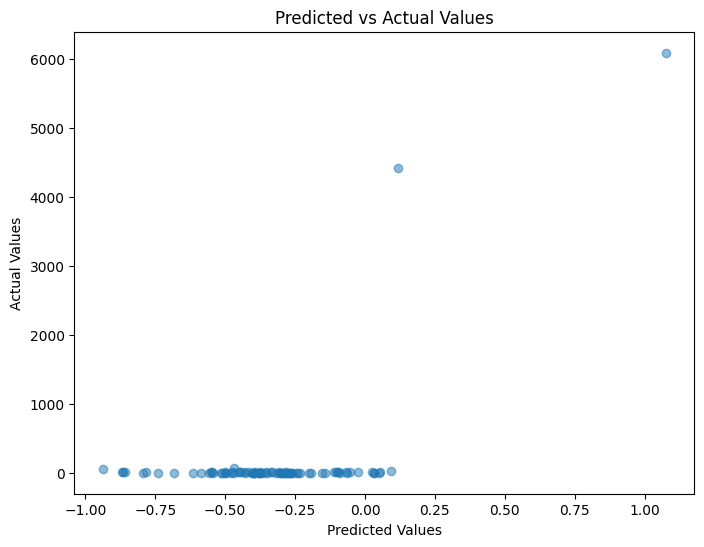

In [149]:
prots = list(df_om.columns[3::3])
ind = 15
print(df_om.columns[ind])
rfu_values = df_om.iloc[1:, ind].values

prot = "RCA-I"
matching_row = gb[gb['protein'] == prot].index[0]
target_sequence = gb.iloc[matching_row]['target']

# range_gly = 
gly_test = list(df_om.iloc[1:,2])
# print(gly_test)
# gly_test = gb.columns[:-5]
# Get predictions as a pandas Series or DataFrame with glycan feature names as index/columns

pred = get_lectin_preds(target_sequence, gly_test, leor, reps)['pred'].values
actual = df_om.iloc[1:, ind].values
#actual = gb.loc[matching_row, gly_test].values

# Now actual_clean and pred_clean are aligned by column name
plt.figure(figsize=(8,6))
plt.scatter(pred, actual, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted vs Actual Values')
xlimm = 3
#plt.xlim(-1,2)



In [82]:
gb.iloc[matching_row]['target']

'ADTIVAVELDTYPNTDIGDPSYPHIGIDIKSVRSKKTAKWNMQNGKVGTAHIIYNSVDKRLSAVVSYPNADSATVSYDVDLDNVLPEWVRVGLSASTGLYKETNTILSWSFTSKLKSNSTHETNALHFMFNQFSKDQKDLILQGDATTGTDGNLELTRVSSNGSPQGSSVGRALFYAPVHIWESSAVVASFEATFTFLIKSPDSHPADGIAFFISNIDSSIPSGSTGRLLGLFPDAN'

(-5.0, 5.0)

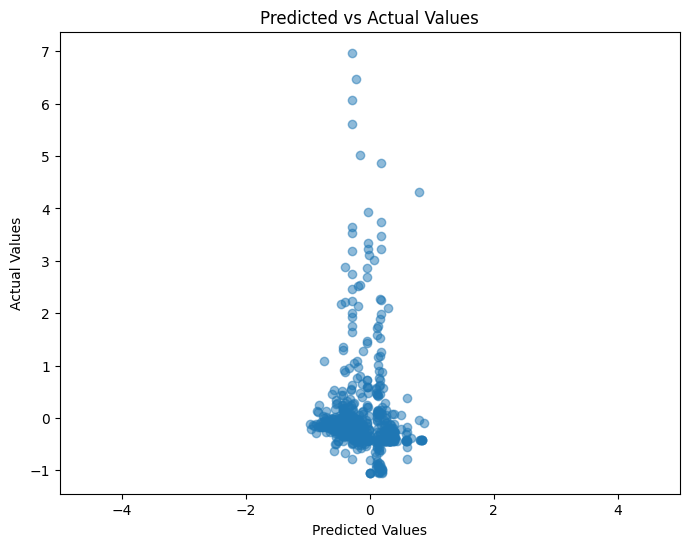

In [86]:
import math 

# Define the columns to use
# reps_ind = 100
# target_sequence = list(reps.keys())[reps_ind]
# matching_row = gb[gb['target'] == target_sequence].index[0]

prot = "GNA"
matching_row = gb[gb['protein'] == prot].index[0]
target_sequence = gb.iloc[matching_row]['target']


n_gly = 2000    
gly_test = gb.columns[:-5]

# Get predictions as a pandas Series or DataFrame with glycan feature names as index/columns
pred = get_lectin_preds(target_sequence, gly_test, leor, reps)['pred'].values
actual = gb.loc[matching_row, gly_test].values

mask = pd.notna(actual)
actual_clean = actual[mask]
pred_clean = pred[mask]

# Now actual_clean and pred_clean are aligned by column name
plt.figure(figsize=(8,6))
plt.scatter(pred_clean, actual_clean, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted vs Actual Values')
xlimm = 5
plt.xlim(-xlimm,xlimm)

(-2.0, 2.0)

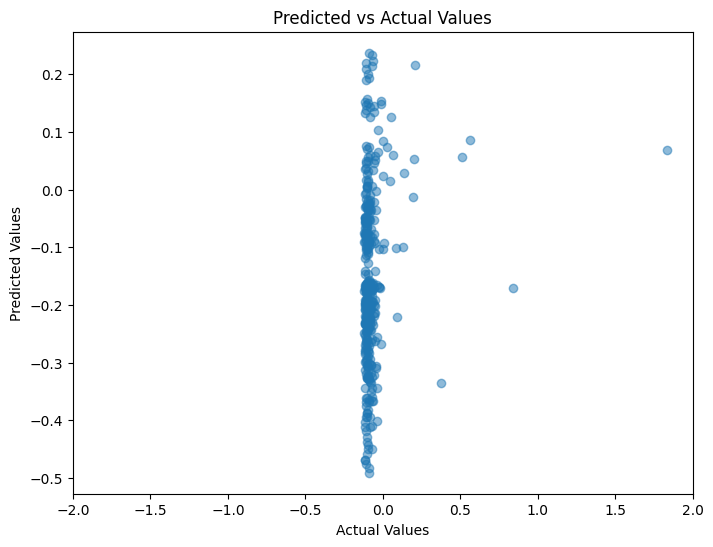

In [59]:
reps_ind = 10
n_gly = 1000
target_sequence = list(reps.keys())[reps_ind]
matching_row = gb[gb['target'] == target_sequence].index[0]

gly_test = gb.columns[:n_gly]
pred = get_lectin_preds(target_sequence, gly_test, leor, reps)['pred']

# Get the actual values and predictions, dropping any NaN values
actual = gb.iloc[matching_row,:n_gly].values
mask = pd.notna(actual)
actual_clean = actual[mask]
pred_clean = pred[mask]

# Create scatter plot
plt.figure(figsize=(8,6))
plt.scatter(actual_clean, pred_clean, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.xlim(-2,2)




In [7]:
df = glycomics_data_loader.human_skin_O_PMC5871710 # imports as a Pandas dataframe
glycans_in_df = list(df['glycan'])
print(glycans_in_df)

['GalOS(b1-3)[Neu5Ac(a2-6)]GalNAc', 'Gal(b1-3)[Neu5Ac(a2-6)]GalNAc', 'Neu5Ac(a2-3)Gal(b1-3)GalNAc', 'Gal(b1-4)GlcNAc(b1-6)[Gal(b1-3)]GalNAc', 'Neu5Ac(a2-3)Gal(b1-3)[Neu5Ac(a2-6)]GalNAc', 'Neu5Ac(a2-3)Gal(b1-3)[Neu5Ac(a2-8)Neu5Ac(a2-6)]GalNAc', 'Fuc(a1-2)Gal(b1-4)GlcNAc(b1-6)[Gal(b1-3)]GalNAc', 'Neu5Ac(a2-3)Gal(b1-3)[Gal(b1-4)GlcNAc6S(b1-6)]GalNAc', 'Neu5Ac(a2-3)Gal(b1-4)GlcNAc6S(b1-6)[Gal(b1-3)]GalNAc', 'Neu5Ac(a2-3)Gal(b1-3)[Gal(b1-4)GlcNAc(b1-6)]GalNAc', 'Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-6)[Gal(b1-3)]GalNAc', 'Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-6)[Neu5Ac(a2-3)Gal(b1-3)]GalNAc', 'Neu5Ac(a2-3)Gal(b1-4)GlcNAc6S(b1-6)[Neu5Ac(a2-3)Gal(b1-3)]GalNAc']


In [17]:
df = glycomics_data_loader.human_skin_O_PMC5871710 # imports as a Pandas dataframe
glycans_in_df = list(df['glycan'])

gly_test = glycans_in_df
gly_test = gb_glycans[:1000]

pred_array = np.zeros((len(valid_seqs), len(gly_test)))
for i, prot_seq in enumerate(valid_seqs):
    pred = get_lectin_preds(prot_seq, gly_test, leor, reps)
    pred_array[i,:] = pred['pred']
    if i%100 == 0:
        print(i)

print("done")


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
done


(array([  2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          2.,   1.,   1.,   3.,   0.,   4.,  13.,  13.,  18.,  15.,  22.,
         44.,  37., 109.,  35.,  59.,  49.,  27.,  45.,  49.,  45.,  63.,
        106., 130., 106., 112., 123.,  95.,  63.,  32.,  16.,  18.,   1.,
          2.,   0.,   0.,   0.,   1.,   1.]),
 array([-1.26690578, -1.24457535, -1.22224491, -1.19991447, -1.17758404,
        -1.1552536 , -1.13292316, -1.11059273, -1.08826229, -1.06593185,
        -1.04360142, -1.02127098, -0.99894054, -0.97661011, -0.95427967,
        -0.93194923, -0.9096188 , -0.88728836, -0.86495792, -0.84262749,
        -0.82029705, -0.79796661, -0.77563618, -0.75330574, -0.7309753 ,
        -0.70864487, -0.68631443, -0.66398399, -0.64165356, -0.61932312,
        -0.59699268, -0.57466225, -0.55233181, -0.53000137, -0.50767094,
        -0.4853405 , -0.46301006, -0.44067963, -0.41834919, -0.39601875,
        -0.37368832, -0.35135788, -0.32902744, -0.30669701, -0.28436657,
 

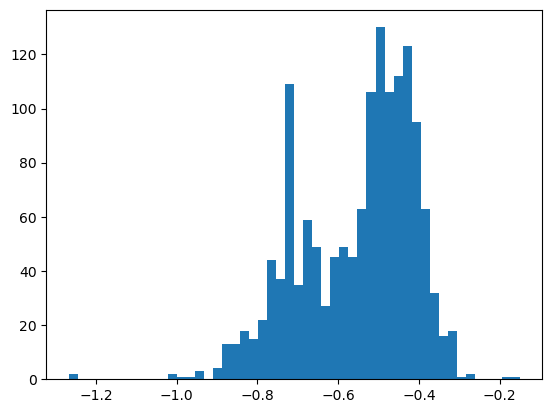

In [18]:
plt.hist(pred_array[:,10], bins = 50)


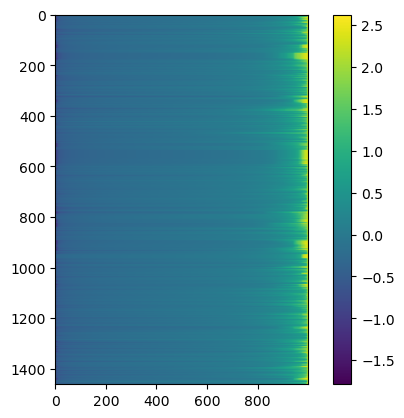

In [20]:
plt.imshow(pred_array)
plt.colorbar()

In [9]:
prot_seq_list = []
prot_seq_list.append(gb[gb['protein'] == "ConA"]['target'].iloc[0])
prot_seq_list.append(gb[gb['protein'] == "WGA"]['target'].iloc[0])

n_gly = len(glycans_in_df)
n_prots = len(prot_seq_list)
z_score_mat = np.zeros((n_prots, n_gly))

for (p, prot_seq) in enumerate(prot_seq_list):
    rep = get_esm1b_representations([prot_seq], model, alphabet)
    predictions = get_lectin_preds(prot_seq, glycans_in_df, leor, rep)
    z_scores = list([predictions['pred'][i] for i in range(len(predictions['pred']))])
    z_score_mat[p,:] = z_scores




NameError: name 'get_esm1b_representations' is not defined

In [7]:
from glycowork.glycan_data.loader import glycomics_data_loader
df = glycomics_data_loader.human_skin_O_PMC5871710 # imports as a Pandas dataframe
glycans_in_df = list(df['glycan'])

In [129]:
df.head()

,glycan,control_1,tumor_1,control_2,tumor_2,control_3,tumor_3,control_4,tumor_4,control_5,tumor_5,control_6,tumor_6,control_7,tumor_7,control_8,tumor_8,control_9,tumor_9
0,GalOS(b1-3)[Neu5Ac(a2-6)]GalNAc,2.755913,0.620301,3.019806,4.148615,2.413021,0.424605,1.764977,0.744528,4.518547,0.849240,3.174455,1.543922,3.752813,1.287601,1.574444,0.627539,4.415230,0.425039
1,Gal(b1-3)[Neu5Ac(a2-6)]GalNAc,0.775234,0.178490,0.778083,0.832907,0.824018,0.410873,0.617573,2.133773,0.603573,0.544599,1.317444,1.256997,0.860332,0.340373,0.927956,0.494144,1.045950,0.590404
2,Neu5Ac(a2-3)Gal(b1-3)GalNAc,9.219494,8.436141,16.190721,11.032313,16.061363,8.133529,12.291188,10.143781,10.865172,14.353894,12.313024,11.601938,13.246380,8.352032,12.352587,9.731834,16.170263,12.693331
3,Gal(b1-4)GlcNAc(b1-6)[Gal(b1-3)]GalNAc,2.770825,0.944913,1.531698,2.427562,1.570204,2.066165,2.832475,2.508954,2.228299,1.757840,4.811796,3.641077,1.437487,1.470697,2.324956,2.192553,0.805130,1.100490
4,Neu5Ac(a2-3)Gal(b1-3)[Neu5Ac(a2-6)]GalNAc,35.912676,30.058418,48.420833,43.738436,46.692847,26.728713,39.971128,32.290024,51.472292,40.669153,41.927351,37.755641,43.701528,32.565498,47.145757,38.565763,44.683562,33.532942


In [8]:
aff_mat = np.exp(0.2 * z_score_mat)
print(aff_mat)

def prob_dist(vals):
    return vals / np.sum(vals)

NameError: name 'z_score_mat' is not defined

In [137]:
group1_list = list(df.columns)[1:-1:2]
group2_list = list(df.columns)[2:-1:2]

activation1_array = np.zeros((len(group1_list), 2))
for (i, g) in enumerate(group1_list):
    glycan_dist = prob_dist(np.array(df[g]))
    activation1_array[i,:] = np.dot(aff_mat, glycan_dist)


activation2_array = np.zeros((len(group2_list), 2))
for (i, g) in enumerate(group2_list):
    glycan_dist = prob_dist(np.array(df[g]))
    activation2_array[i,:] = np.dot(aff_mat, glycan_dist)

In [126]:
activation2_array

array([[0.40275825, 0.77498617],
       [0.40424607, 0.74449065],
       [0.41015974, 0.81003685],
       [0.43099077, 0.7973172 ],
       [0.42538376, 0.72558546],
       [0.42550455, 0.80023557],
       [0.39551569, 0.78812702],
       [0.41845677, 0.73818347]])

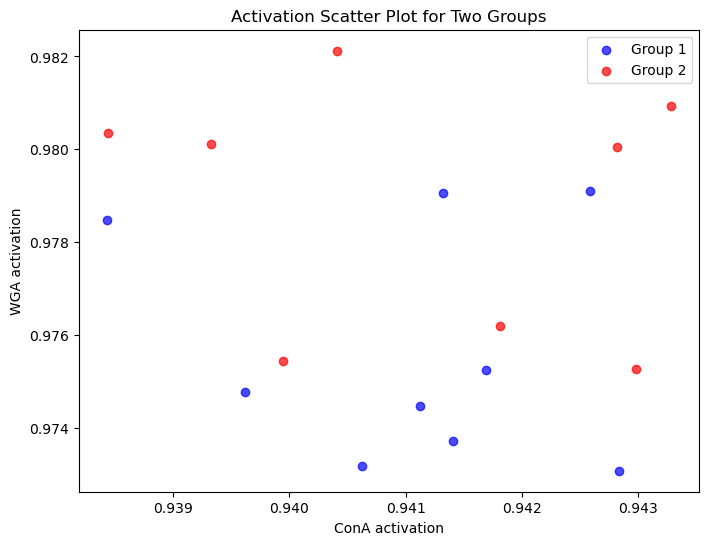

In [138]:
# Plot scatter plots for both groups
plt.figure(figsize=(8, 6))
plt.scatter(activation1_array[:,0], activation1_array[:,1], color='blue', label='Group 1', alpha=0.7)
plt.scatter(activation2_array[:,0], activation2_array[:,1], color='red', label='Group 2', alpha=0.7)

# Labels and legend
plt.xlabel('ConA activation')
plt.ylabel('WGA activation')
plt.title('Activation Scatter Plot for Two Groups')
plt.legend()
plt.show()

Measured binding code

In [5]:
conditions_df = glycomics_data_loader.human_skin_O_PMC5871710 # imports as a Pandas dataframe
glycans_in_df = list(conditions_df['glycan'])
print(glycans_in_df)

['GalOS(b1-3)[Neu5Ac(a2-6)]GalNAc', 'Gal(b1-3)[Neu5Ac(a2-6)]GalNAc', 'Neu5Ac(a2-3)Gal(b1-3)GalNAc', 'Gal(b1-4)GlcNAc(b1-6)[Gal(b1-3)]GalNAc', 'Neu5Ac(a2-3)Gal(b1-3)[Neu5Ac(a2-6)]GalNAc', 'Neu5Ac(a2-3)Gal(b1-3)[Neu5Ac(a2-8)Neu5Ac(a2-6)]GalNAc', 'Fuc(a1-2)Gal(b1-4)GlcNAc(b1-6)[Gal(b1-3)]GalNAc', 'Neu5Ac(a2-3)Gal(b1-3)[Gal(b1-4)GlcNAc6S(b1-6)]GalNAc', 'Neu5Ac(a2-3)Gal(b1-4)GlcNAc6S(b1-6)[Gal(b1-3)]GalNAc', 'Neu5Ac(a2-3)Gal(b1-3)[Gal(b1-4)GlcNAc(b1-6)]GalNAc', 'Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-6)[Gal(b1-3)]GalNAc', 'Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-6)[Neu5Ac(a2-3)Gal(b1-3)]GalNAc', 'Neu5Ac(a2-3)Gal(b1-4)GlcNAc6S(b1-6)[Neu5Ac(a2-3)Gal(b1-3)]GalNAc']


/var/folders/vz/mzz963fn35g6stbyn1w_x0jc0000gn/T/ipykernel_59448/2534349422.py:20: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  z_score_mat[p, i] = 0 if np.isnan(prot_row[gly].to_numpy()) else prot_row[gly]


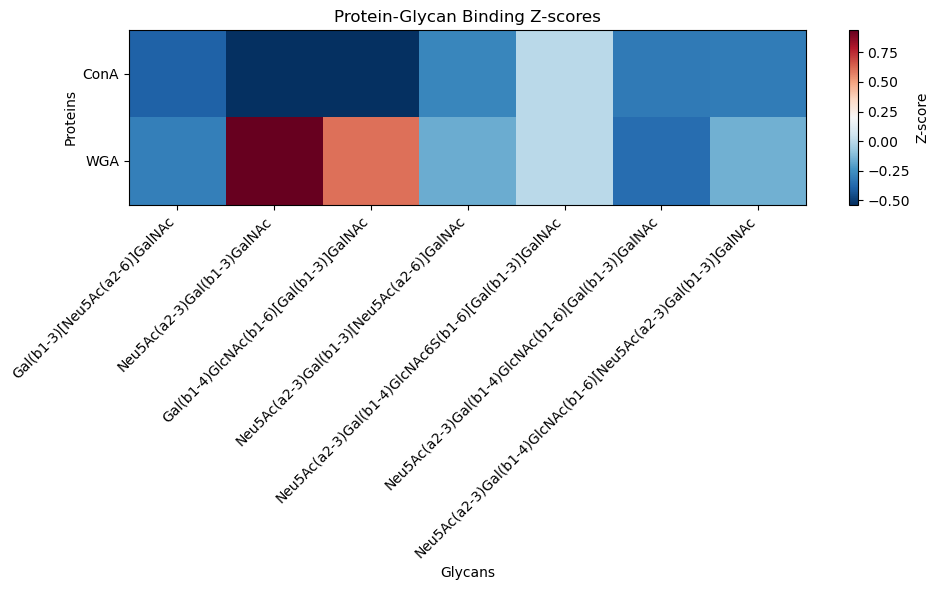

In [42]:
prot_seq_list = []
prot_seq_list.append(gb[gb['protein'] == "ConA"]['target'].iloc[0])
prot_seq_list.append(gb[gb['protein'] == "WGA"]['target'].iloc[0])

# Filter glycans_in_df to only include those that exist in gb.columns
# Get mask of glycans that exist in both dataframes
glycan_mask = [gly in gb.columns for gly in glycans_in_df]
glycans_in_df_and_gb = [gly for gly, mask in zip(glycans_in_df, glycan_mask) if mask]

n_gly = len(glycans_in_df_and_gb)
n_prots = len(prot_seq_list)
z_score_mat = np.zeros((n_prots, n_gly))


for (p, prot_seq) in enumerate(prot_seq_list):
    prot_row = gb[gb['target'] == prot_seq]
    for (i, gly) in enumerate(glycans_in_df_and_gb):
        #if gly in prot_row.columns:
        gly_ind = glycans_in_df.index(gly)
        z_score_mat[p, i] = 0 if np.isnan(prot_row[gly].to_numpy()) else prot_row[gly]

# Create heatmap
plt.figure(figsize=(10, 6))
plt.imshow(z_score_mat, aspect='auto', cmap='RdBu_r')
plt.colorbar(label='Z-score')

# Add labels
plt.xlabel('Glycans')
plt.ylabel('Proteins')
plt.title('Protein-Glycan Binding Z-scores')

# Add protein labels
plt.yticks([0, 1], ['ConA', 'WGA'])

# Rotate x-axis labels for readability if needed
plt.xticks(range(len(glycans_in_df_and_gb)), glycans_in_df_and_gb, rotation=45, ha='right')

plt.tight_layout()
plt.show()

   


In [41]:
aff_mat = np.exp(0.2 * z_score_mat)
aff_mat = z_score_mat
print(aff_mat)

def prob_dist(vals):
    return vals / np.sum(vals)

group1_list = list(df.columns)[1:-1:2]
group2_list = list(df.columns)[2:-1:2]

activation1_array = np.zeros((len(group1_list), 2))
for (i, g) in enumerate(group1_list):
    glycan_dist = prob_dist(np.array(df[g]))
    activation1_array[i,:] = np.dot(aff_mat, glycan_dist)


activation2_array = np.zeros((len(group2_list), 2))
for (i, g) in enumerate(group2_list):
    glycan_dist = prob_dist(np.array(df[g]))
    activation2_array[i,:] = np.dot(aff_mat, glycan_dist)

# Plot scatter plots for both groups
plt.figure(figsize=(8, 6))
plt.scatter(activation1_array[:,0], activation1_array[:,1], color='blue', label='Group 1', alpha=0.7)
plt.scatter(activation2_array[:,0], activation2_array[:,1], color='red', label='Group 2', alpha=0.7)

# Labels and legend
plt.xlabel('ConA activation')
plt.ylabel('WGA activation')
plt.title('Activation Scatter Plot for Two Groups')
plt.legend()
plt.show()

[[-0.39132203 -0.5347117  -0.53177955 -0.27891915  0.         -0.32127398
  -0.31611426]
 [-0.29980114  0.93509258  0.60307239 -0.16534969  0.         -0.35691953
  -0.15127527]]


ValueError: shapes (2,7) and (13,) not aligned: 7 (dim 1) != 13 (dim 0)